In [1]:
# default_exp data.load_pd

In [2]:
# hide
import sys

sys.path.append("..")
import pandas as pd

/home/tako/dev/env37/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
# export
from fastseq.core import *
from fastseq.data.external import *
from fastcore.utils import *
from fastcore.imports import *
from fastai2.basics import *
from fastai2.data.transforms import *
from fastai2.tabular.core import *

In [4]:
# hide
from nbdev.showdoc import *

# Data Load Dataframe


> Using the fastai2 `Datasets` to make an time series dataset.

A multivaraite time-series dataloader. 

TODO reduce mem: https://forums.fast.ai/t/how-to-handle-dataframes-too-large-to-fit-in-memory/39208/19

In [5]:
# export
import numpy as np
import pandas as pd

In [6]:
# export
class TSMulti(MultiTuple):pass

# Dataloader

In [7]:
# export
@delegates()
class DfDataLoader(TfmdDL):
    def __init__(self, dataset:pd.DataFrame, y_name:str, horizon:int, lookback=72, step=1, min_seq_len=None, max_std= None, norm=True, **kwargs):
        store_attr(self,'horizon,lookback,step,max_std,norm,y_name')
        self.min_seq_len = ifnone(min_seq_len, lookback)
        self.dataset = dataset
        self.con_names, self.cat_names, self.ts_names = L(), L(), L()
        for col in dataset.columns:
            t = type(dataset[col].iloc[0])
            if t is pd.core.series.Series:
                self.ts_names.append(col)
            elif t is np.ndarray:
                self.dataset[col] = pd.Series([pd.Series(o.flatten()) for o in self.dataset[col]])
                self.ts_names.append(col)
            elif isinstance(dataset[col].iloc[0], int) or t is np.int64:
                self.con_names.append(col)
            elif isinstance(dataset[col].iloc[0], float):
                self.cat_names.append(col)
            else:
                raise Exception(t) 
        assert y_name in self.ts_names
        self.ts_names.remove(y_name)
        n = self.make_ids()
        super().__init__(dataset=self.dataset, **kwargs)
        self.n = n
        self.skipped= []      

    @delegates(TfmdDL.new)
    def new(self, dataset=None, cls=None, **kwargs):
        for k,v in {k:getattr(self,k) for k in ['horizon', 'lookback', 'step']}.items():
            if k not in kwargs:
                kwargs[k] = v
        res = super().new(dataset = dataset,cls= cls, y_name= self.y_name, **kwargs)
        res.make_ids()
        return res
    
    def check_std(self, r):  
        if self.max_std is not None:
            if (r[-1]/(r[0].std()+1e-7)).std() > self.max_std:
                if idx not in self.skipped:
                    self.skipped.append(idx)
                raise SkipItemException()
        
    def make_ids(self):
        """Make ids if the sequence is shorter than `min_seq_len`, it will drop that sequence."""
        # Slice each time series into examples, assigning IDs to each
        last_id = 0
        n_dropped = 0
        n_needs_padding = 0
        self._ids = {}
        for i, ts in self.dataset.iterrows(): 
            assert same_size_ts(ts, self.ts_names), f"row {i} are not all the time series the same length"
            num_examples = (ts[self.y_name].shape[-1] - self.lookback - self.horizon + self.step) // self.step
            # Time series shorter than the forecast horizon need to be dropped.
            if ts[self.y_name].shape[-1] < self.min_seq_len:
                n_dropped += 1
                continue
            # For short time series zero pad the input
            if ts[self.y_name].shape[-1] < self.lookback + self.horizon:
                n_needs_padding += 1
                num_examples = 1
            for j in range(num_examples):
                self._ids[last_id + j] = (i, j * self.step)
            last_id += num_examples

        # Inform user about time series that were too short
        if n_dropped > 0:
            print("Dropped {}/{} time series due to length.".format(
                    n_dropped, len(self.dataset)))

        # Inform user about time series that were short
        if n_needs_padding > 0:
            print("Need to pad {}/{} time series due to length.".format(
                    n_needs_padding, len(self.dataset)))
        # Store the number of training examples
        return int(self._ids.__len__() )
    
        def shuffle_fn(self, idxs):
#         self.dataset.shuffle()        
            return idxs

    def get_id(self, idx):
        ts_id, lookback_id = self._ids[idx]
        row = self.dataset.iloc[ts_id, :]
        x = get_part_of_ts(row[self.y_name].values, lookback_id, self.lookback)        
        y = get_part_of_ts(row[self.y_name].values, lookback_id, self.lookback + self.horizon)
        tsx = np.concatenate([o[None,:] for o in row[self.ts_names].to_numpy()])
        tsx = get_part_of_ts(tsx, lookback_id, self.lookback + self.horizon)
        r = [TensorSeqs(x, label=[self.y_name + '_x'], m=['g']), 
             TensorSeqs(tsx, label=self.ts_names)]
        r.append(TensorCon(row[self.cat_names].to_numpy().astype(float),label=self.cat_names))
        # TODO make cat its own type
        r.append(TensorCon(row[self.con_names].to_numpy().astype(float),label=self.con_names))            
        # TODO make y its own type
        r.append(TensorSeqs(y, label=[self.y_name+ '_y'], m=['g']))
        return tuple(r)

    def create_item(self, idx):
        if idx>=self.n:
            raise IndexError
        r  = self.get_id(idx)
        self.check_std(r)     
        return TSMulti(r)
        
    

The data will be stored in pandas DataFrames. This can be use for time series by nesting series into a cell. An example is shown below: 

In [8]:
df = pd.DataFrame(data={'pred':[np.arange(10.),
                           np.arange(12.)],
                   'ts_0':[np.ones(10)[None,:],
                           np.ones(12)[None,:]],
                   'ts_1':[pd.Series(np.arange(1,11)+np.random.randn(10)),
                           pd.Series(np.arange(1,13)+np.random.randn(12))],
                   'var_0':[0.,1.],
                   'con_0':[0,1]})
df

,pred,ts_0,ts_1,var_0,con_0
0,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]",0 -0.422253 1 1.751815 2 5.074496 3 2.746533 4 4.103737 5 6.165418 6 7.578102 7 8.745983 8 7.696089 9 9.507965 dtype: float64,0.0,0
1,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0]","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]",0 1.347630 1 2.351420 2 3.496136 3 5.321267 4 5.781265 5 5.462875 6 6.994977 7 8.358109 8 8.459375 9 12.450190 10 9.597838 11 12.655721 dtype: float64,1.0,1


In [9]:
horizon,lookback = 2,9
dl = DfDataLoader(df, 'pred', horizon = horizon, lookback = lookback)


Need to pad 1/2 time series due to length.


In [10]:
for o in dl:
    test_eq(type(o), TSMulti)
    test_eq(len(o),5)
    dct = {k:v for k,v in zip(['x','tsx','cat','con','y'], o)}
    test_eq(type(o), TSMulti)
    test_eq(dct['x'].shape[1:], (1,lookback))
    test_eq(dct['y'].shape[1:], (1,lookback+horizon))
    test_eq(dct['tsx'].shape[1:], (2,lookback+horizon))
    break

In [16]:
# hide
# without cat or con
horizon,lookback = 3,5
dl = DfDataLoader(df[['pred','ts_0']], 'pred', horizon = horizon, lookback = lookback)


for o in dl:
    test_eq(type(o), TSMulti)
    test_eq(len(o),5)
    dct = {k:v for k,v in zip(['x','tsx','cat','con','y'], o)}
    test_eq(type(o), TSMulti)
    test_eq(dct['x'].shape[1:], (1,lookback))
    test_eq(dct['y'].shape[1:], (1,lookback+horizon))
    test_eq(dct['cat'].shape[1:], ([0]))
    test_eq(dct['con'].shape[1:], ([0]))
    test_eq(dct['tsx'].shape[1:], (1,lookback+horizon))
    
test_eq(first(dl), dl.one_batch())

In [14]:
# hide
# test self.new
dl.new()

# Showing

In [18]:
# export
from fastai2.vision.data import get_grid
@typedispatch
def show_batch(x:TSMulti, none_1, none_2, *args, ctxs=None, max_n=10, rows=None, cols=None, figsize=None, **kwargs):
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), add_vert=1, figsize=figsize, **kwargs)
    for i, ctx in enumerate(ctxs):  
        o = TSMulti([type(o)(o[i],**o._meta) for o in x])
        ctx = o.show(ctx=ctx)
    return ctxs


Need to pad 1/2 time series due to length.


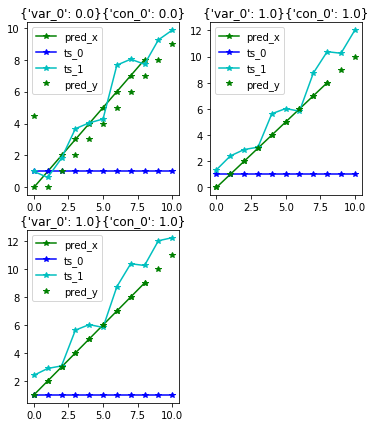

In [19]:
horizon,lookback = 2,9
dl = DfDataLoader(df, 'pred', horizon = horizon, lookback = lookback)
dl.show_batch()

In [20]:
#export
from fastseq.data.load_pd import *

@typedispatch
def show_results(x:TSMulti, x1, none_1, none_2, ctxs=None, max_n=9,rows=None, cols=None, figsize=None, **kwargs):
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), add_vert=1, figsize=figsize, **kwargs)
    for i, ctx in enumerate(ctxs):  
        r = [type(o)(o[i],**o._meta) for o in x]
        r.append(type(x1[-1])(x1[-1][i],label=['pred'],m=['r']))
        o = TSMulti(r)
        ctx = o.show(ctx=ctx)
        


(#4) [0,256.1754455566406,235.1352081298828,'00:00']
Need to pad 1/2 time series due to length.
Need to pad 1/2 time series due to length.


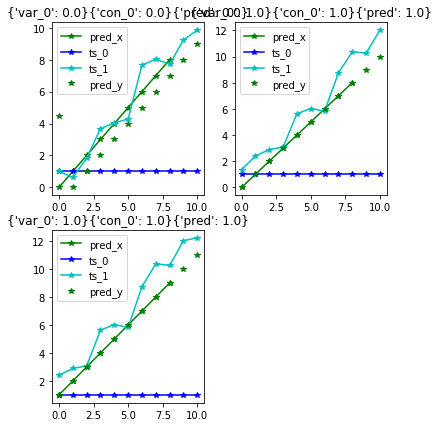

In [21]:
class RegModel(Module):
    def __init__(self,in_f,out_f): 
        self.a,self.b = nn.Parameter(torch.randn(in_f,in_f+out_f)),nn.Parameter(torch.randn(in_f+out_f))
    def forward(self, x, *args): return (torch.mm(x[:,0,:],self.a) + self.b)[:,None,:]
    
def synth_learner(lookback, horizon, cuda=False, lr=1e-3, data=None, **kwargs):
    return Learner(data, RegModel(lookback,horizon), lr=lr, loss_func=MSELossFlat(),
                   opt_func=partial(SGD, mom=0.9), **kwargs)

learn = synth_learner(lookback, horizon, data=DataLoaders(dl,dl))
learn.fit(1)
learn.show_results(max_n=9)

# Intergration Example

In [22]:
from fastseq.data.external import *

In [23]:
horizon,lookback = 5,10
df = dummy_data_generator_multi(32)
df['city_int'] = df['city'].astype(int) 
df['city'] = df['city'].astype(float)
df.head()

,x,weather,city,cont,city_int
0,"[[-1.6545826995693713, -1.8962039724804423, -2.020010658362782, -1.730509930873108, -1.4004138362743854, -0.6188848001366333, -0.4113118622786649, -0.24308420657669388, 0.1310488102018226, 0.022341043008653805, 0.22020813944023857, 0.22162697697912156, 0.4653970027623527, 0.5219833584054515, 0.4253467656522679, 0.20226192489176736, -0.19934768889969737, -0.5248190018179512, -0.5964597500444873, -0.7078451443590174, -0.4363643744683275, -0.27318356152794987, 0.04689965906782903, 0.4916756061283917, 0.878950782784596, 0.7176724302281765, 0.9429076566293316, 1.0849076499718326, 1.310855689792...","[[4.912036621697602, 4.396744700372091, 3.9899315503000428, 4.161624855327871, 4.936219237507324, 5.858760049586205, 6.292330683121753, 5.8503859139033665, 4.676061589013079, 3.3795641746369522, 2.669520148932561, 2.9161584654129893, 3.9298334133938924, 5.097381461946815, 5.784201522833928, 5.736621765149894, 4.912036621697602, 4.396744700372091, 3.9899315503000428, 4.161624855327871, 4.936219237507324, 5.858760049586205, 6.292330683121753, 5.8503859139033665, 4.676061589013079, 3.3795641746369522, 2.669520148932561, 2.9161584654129893, 3.9298334133938924, 5.097381461946815, 5.784201522833...",0.0,0.600822,0
1,"[[0.7042814350100155, -0.036476688620550334, 0.16883293943904193, 0.6223666666431322, 1.0756708454450765, 1.4552472646531305, 1.612725630865821, 1.9461753340744217, 2.056335502696391, 2.003201876896889, 1.0832421425756382, -0.015995360712316734, -0.45424929127651575, -0.7453189945093006, -0.7911707517713928, -0.6094113838024641, -0.49777804877438614, -0.45423425920766086, -0.02837115165410321, 0.3897645736007013, 0.21637530481271697, -0.4317623411440878, -0.8675333253522332, -0.7048901711765083, -0.8217829374596974, -0.8854893832192554, -0.5836719591386729, -1.0522455196669969, -0.90772027...","[[4.171845454091086, 3.6094662336479573, 4.284763931200164, 5.677489344827339, 6.125085526500635, 5.074391028743372, 3.8342145782776185, 3.790801963743678, 4.548175525459059, 4.55363642258083, 3.3304724150042295, 2.2173137745354268, 2.578443756545636, 3.9479356112557715, 4.667249684044012, 4.136242035580336, 4.171845454091086, 3.6094662336479573, 4.284763931200164, 5.677489344827339, 6.125085526500635, 5.074391028743372, 3.8342145782776185, 3.790801963743678, 4.548175525459059, 4.55363642258083, 3.3304724150042295, 2.2173137745354268, 2.578443756545636, 3.9479356112557715, 4.66724968404401...",0.0,0.285355,0
2,"[[-1.847531212868434, -1.9304974714215735, -1.6684598840164921, -1.122910349725474, -0.541730658754978, -0.5045618526938233, -0.1567409596884141, 0.04520401049679192, 0.16769634822394727, 0.22312768829916144, -0.453732331515737, -0.6981744599860401, -0.7255246212727225, -0.7302056728839608, -0.7230619214173123, -0.49313626366194574, -0.07651729517133175, 0.16749880732199451, 0.7515873783594565, 0.8605520016810265, 0.7398077990911358, -0.08690644651694505, -0.43307840111479273, -0.3018705355157967, 0.023601901155770665, 0.42783376836337816, 0.6815868812286686, 1.0417036055438174, 1.56014819...","[[6.848695008580922, 6.769561589676616, 8.449391304842736, 10.292180012132174, 10.283548534600127, 8.476242208237203, 6.846971308971423, 6.7644907605363755, 7.448845685821876, 7.347337243984994, 6.367230412348647, 5.864646327625744, 6.535966695981555, 7.309357984169666, 6.8781027664842265, 5.717812043621975, 6.848695008580922, 6.769561589676616, 8.449391304842736, 10.292180012132174, 10.283548534600127, 8.476242208237203, 6.846971308971423, 6.7644907605363755, 7.448845685821876, 7.347337243984994, 6.367230412348647, 5.864646327625744, 6.535966695981555, 7.309357984169666, 6.878102766484226...",0.0,-0.122364,0
3,"[[1.9494201138628529, 1.7900217417857975, 1.5659037881353899, 0.9439943863668797, 0.7949693505520739, 0.570902638022397, 0.4375916772426506, 0.6190836924885618, 0.6313174245362473, 0.5974151167273141, 0.47658222233053077, 0.7457846805197129, 0.7240470334120239, 0.320507951492903, -0.05431105893985747, 

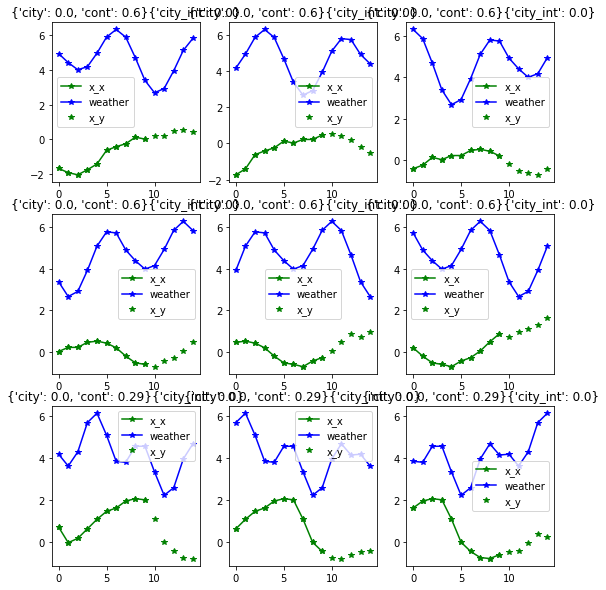

In [24]:
dl = DfDataLoader(df, 'x', horizon = horizon, lookback = lookback, step=3, bs=32)
dl.show_batch(max_n=9)

In [ ]:
# hide
from nbdev.export import *

notebook2script()

Converted 00_core.ipynb.
Converted 01_data.external.ipynb.
Converted 020_data.load_pd.ipynb.
Converted 02_data.load.ipynb.
Converted 030_data.core_pd.ipynb.
Converted 03_data.core.ipynb.
Converted 050_nbeats.models_multi.ipynb.
